# Final Model
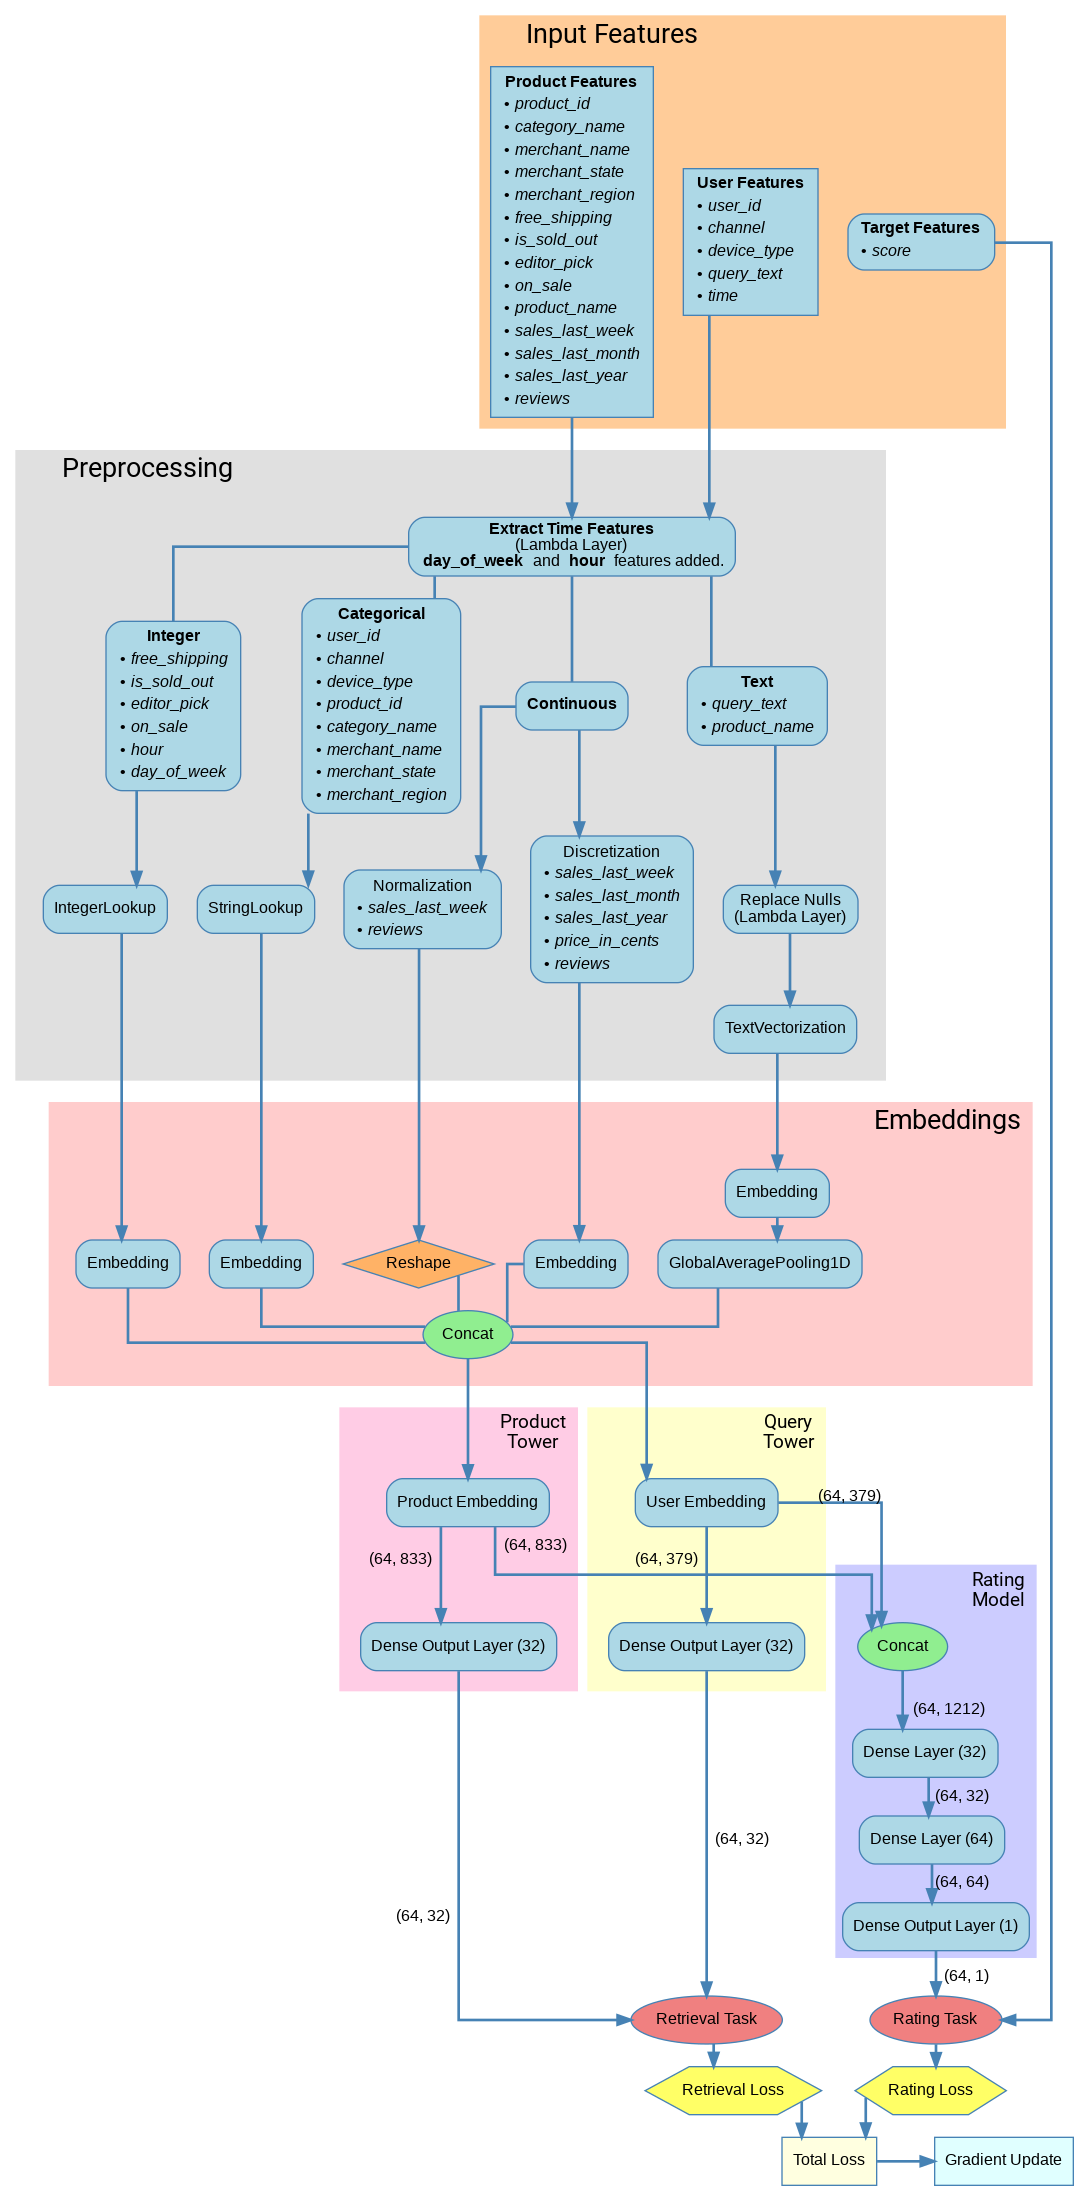
**NOTE**: Shape dimensions are (batch_size, tensor_size).

In [1]:
import sys
import warnings
import json
import pprint
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add the root path to sys.path
root_path = Path().resolve().parent
sys.path.append(str(root_path))

from src.train_functions import train_CV
from src.inference import RecommendationEngine

# Hide warnings
warnings.filterwarnings("ignore")

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 50)

# Set Seaborn style
sns.set_style('darkgrid')
sns.set_context('notebook')
sns.set_palette('colorblind')

2025-04-04 09:42:03.916077: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-04 09:42:03.916137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-04 09:42:03.916965: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-04 09:42:03.923222: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-04 09:42:04.652153: W tensorflow/compiler/tf2

In [2]:
# Load params
parameters_path = root_path / "output" / "model" / "parameters"
params = json.loads(open(parameters_path / "params_v3.json").read())

# Model final parameters
pprint.pprint(params)

{'callbacks': {'early_stopping': {'delta_rating': 0.01,
                                  'delta_retrieval': 0.01,
                                  'patience': 3,
                                  'rating_metric': 'val_root_mean_squared_error',
                                  'retrieval_metric': 'val_factorized_top_k/top_50_categorical_accuracy',
                                  'start_from_epoch': 5}},
 'logs_path': '',
 'model': {'batch_size': 128,
           'cross_layer': False,
           'dropout': 0.1,
           'emb_weight': 8,
           'learning_rate': {'decay_rate': 0.57,
                             'initial_learning_rate': 0.1,
                             'staircase': True},
           'max_epochs': 300,
           'optimizer': 'Adagrad',
           'product_layers': [32],
           'rating_layers': [64, 32, 1],
           'user_layers': [32]},
 'n_samples': 21420,
 'tower': {'candidate': ['cat-product_id',
                         'cat-category_name',
            

## Cross Validation Evaluation
I will evaluate my model using cross-validation.

In [ ]:
params['logs_path'] = root_path / "output" / "logs" / "selected_model"

results_df = train_CV(params)

Cross Validation: 100%|██████████| 5/5 [05:33<00:00, 66.67s/fold]


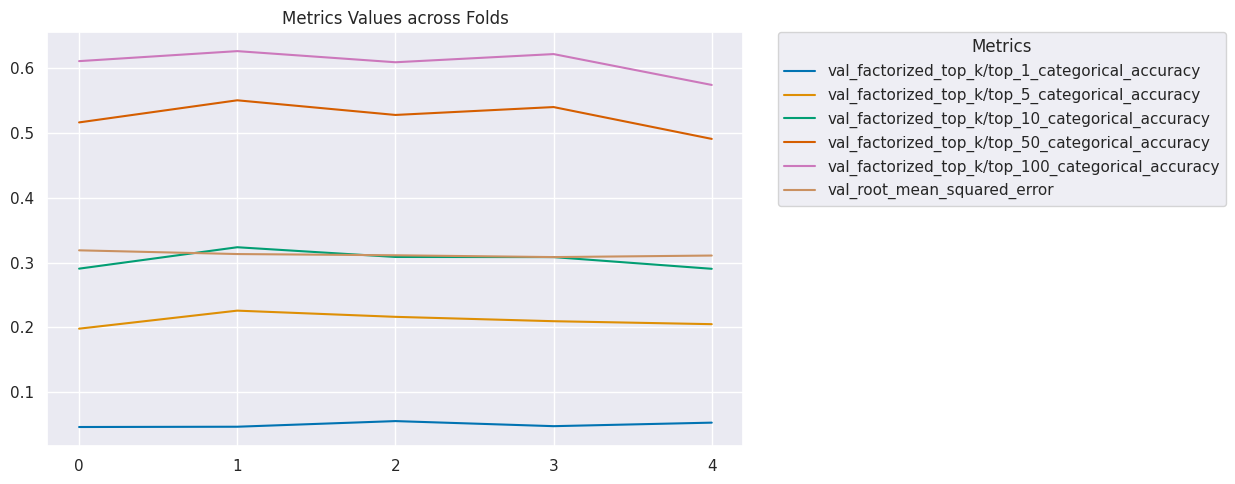

In [ ]:
cv_data = results_df.drop(['n_epochs', 'val_loss', 'val_regularization_loss', 'val_total_loss', 'fold'], axis=1)
fig = plt.figure(figsize=(15, 5))

for col in cv_data.columns:
    plt.plot(cv_data[col], label=col)

plt.xticks(range(0, 5))
plt.title('Metrics Values across Folds')
# Move the legend outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Metrics')

# Use tight layout to automatically adjust subplot params
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right for the legend
plt.show()

In [ ]:
# Metrics average
cv_data.mean()

val_factorized_top_k/top_1_categorical_accuracy      0.050174
val_factorized_top_k/top_5_categorical_accuracy      0.211024
val_factorized_top_k/top_10_categorical_accuracy     0.304297
val_factorized_top_k/top_50_categorical_accuracy     0.524609
val_factorized_top_k/top_100_categorical_accuracy    0.607812
val_root_mean_squared_error                          0.312454
dtype: float64

The obtained metric for `val_factorized_top_k/top_50_categorical_accuracy` is **0.52** and for `val_root_mean_squared_error` is **0.31**.
This tell us that, on average, the true positive is in the top 50 retrieved items 52% of the time. The ranking metric idea is to improve the position of the true positive in the retrieved list.

# Prediction

Make a prediction in order to initialize the model and build the imput tensor shape.

**Model Usage:**  
This process retrieves and ranks product recommendations based on user queries.  

1. **Retrieve Top Recommendations:**  
   Using the retrieval index, extract the top 1,000 recommendations for the given user query. These represent the products that the user is most likely to click on.  

2. **Predict Scores:**  
   For each pair of user query and recommended product, predict a relevance score using historical user feedback data. This score reflects the likelihood of the product being purchased.  

3. **Rank by Purchase Probability:**  
   Sort the recommendations based on the predicted scores in descending order. Items with scores closer to 1 are deemed highly purchaseable, while those closer to 0 are less likely to be purchased.

In [3]:
query_input = {
    'user_id': 'b7485193f4e7f5b8ac3c94f71f4456a9',
    'channel': 'Organic',
    'device_type': 'Desktop',
    'query_text': 'pizza',
    'time': '2023-10-25 00:00:19.230',
}

recommender = RecommendationEngine()
recommendations = recommender.get_recommendations(query_input)
pd.DataFrame(recommendations)

2025-04-04 09:42:08.898648: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-04 09:42:08.957116: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-04 09:42:08.957195: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-04 09:42:08.962667: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-04 09:42:08.962810: I external/local_xla/xla/stream_executor

[09:42:10] WARNING  No training configuration found in save file, so the model was *not* compiled. Compile it      
                    manually.

,score,product_name,category,price_in_cents,reviews,merchant,city,state,region,free_shipping,sold_out,editors_pick,on_sale
0,0.253093,Key Lime Pie,Key Lime Pies,8495,60,Kermit's Key West Key Lime Shoppe,Key West,FL Florida,south,1,0,1,0
1,0.245077,2 Lou Malnati's Deep Dish Pizzas,Chicago Deep Dish Pizza,8399,85,Lou Malnati's Pizza,Chicago,IL Illinois,midwest,1,0,0,0
2,0.235450,Bagels - Bakers Dozen,,5995,71,Utopia Bagels,Queens,NY New York,northeast,1,0,1,0
3,0.232289,Famous Key West Key Lime Pie,Key Lime Pies,6995,24,Key West Key Lime Pie Co.,Key West,FL Florida,south,1,0,0,0
4,0.229522,Halloween ''''Spooky Eyes'''' Brownie Bruffles,Brownies,5995,66,Brownie Points,Columbus,OH Ohio,midwest,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.040529,Deluxe Combo Colorado Pizza - 3 Pack,Colorado-Style Pizza,9995,21,Panhandler's Pizza,Fort Collins,CO Colorado,west,1,0,0,0
996,-0.040724,Pepperoni Colorado Pizza - 3 Pack,Colorado-Style Pizza,9995,21,Panhandler's Pizza,Fort Collins,CO Colorado,west,1,0,0,0
997,-0.042369,Chicken Burrito Kit - 6 Pack,Meal Kits,10495,24,Chef Tim Love,Fort Worth,TX Texas,southwest,1,0,0,0
998,-0.048521,Sausage Pizza - 4 Pack,Pizza,12495,46,Regina Pizzeria,Boston,MA Massachusetts,northeast,1,0,0,0
